🌱 인프런 📚 모두의 한국어 텍스트 분석과 자연어처리 with 파이썬 🐍 https://inf.run/FX4TP


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/python-text-analysis/blob/main/0304-klue-pecab-hyperparameter-output.ipynb)


## 연합뉴스 타이틀 주제 분류
* 데이터셋 출처 : 
    * [뉴스 토픽 분류 AI 경진대회 - DACON](https://dacon.io/competitions/official/235747/overview/description)

## Grid Search 와 Random Search

<img src="https://i.imgur.com/h8QtsMz.png" width=500>

## 라이브러리 로드

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 로드합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

## 데이터 로드

In [2]:
# 학습, 예측 데이터셋을 불러옵니다.
train = pd.read_csv("data/klue/train_data.csv")
test = pd.read_csv("data/klue/test_data.csv")
train.shape, test.shape

((45654, 3), (9131, 2))

In [3]:
# 토픽을 불러옵니다.
topic = pd.read_csv("data/klue/topic_dict.csv")
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


## 형태소 분석

### 형태소 분석기를 통한 조사 구두점 제거
* https://github.com/hyunwoongko/pecab
* 조사, 구두점 제거
* 품사태그표 : 
    * https://konlpy.org/ko/v0.6.0/morph/
    * https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0

In [5]:
# pecab
from pecab import PeCab

pecab = PeCab()

In [13]:
corpus_text = "토끼정에서 크림 우동을 시켰어요."
pecab_pos = pecab.pos(corpus_text, drop_space=False)
join_text = []
for txt, pos in pecab_pos:
    if not pos.startswith("J") and (pos not in ["SF"]) :
        join_text.append(txt)
print("".join(join_text))

토끼정 크림 우동 시켰어요


In [34]:
def corpus_pecab(corpus_text):
    join_text = []
    pecab_pos = pecab.pos(corpus_text, drop_space=False)
    for txt, pos in pecab_pos:
        if not pos.startswith("J") and (pos not in ["SF"]) :
            join_text.append(txt)
    return "".join(join_text)

corpus_pecab("나는 밥을 먹는다. 학교에서 공부를 했어요.")

'나 밥 먹는다 학교 공부 했어요'

In [35]:
train["title"].head()

0            인천→핀란드 항공기 결항…휴가철 여행객 분통
1      실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화
2      이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3    NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
4           시진핑 트럼프에 중미 무역협상 조속 타결 희망
Name: title, dtype: object

In [36]:
# 형태소 분석기를 통한 전처리
train["title"].head().map(corpus_pecab)

0            인천→핀란드 항공기 결항…휴가철 여행객 분통
1      실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화
2        이란 외무 긴장완화 해결책 미국 경제전쟁 멈추는 것
3    NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
4            시진핑 트럼프 중미 무역협상 조속 타결 희망
Name: title, dtype: object

In [37]:
from tqdm import tqdm
tqdm.pandas()

train["title_pecab"] = train["title"].progress_map(corpus_pecab)
test["title_pecab"] = test["title"].progress_map(corpus_pecab)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9131/9131 [01:37<00:00, 93.28it/s]


### 전처리 결과 저장

In [42]:
file_name_train = f"data/klue/train_pecab.csv"
file_name_test = f"data/klue/test_pecab.csv"

train.to_csv(file_name_train, index=False)
test.to_csv(file_name_test, index=False)

In [44]:
pd.read_csv(file_name_train).head(2)

,index,title,topic_idx,title_pecab
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천→핀란드 항공기 결항…휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화


In [45]:
pd.read_csv(file_name_test).head(2)

,index,title,title_pecab
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 2일 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져…남부지방 옅은 황사


## 학습, 예측 데이터셋 만들기

## 벡터화
* 머신러닝이나 딥러닝 알고리즘은 문자를 이해할 수 없습니다. 내부에서는 수치 계산이 이루어지기 때문에 문자를 숫자로 변경해 주어야 합니다.


### TF-IDF(Term Frequency - Inverse Document Frequency)

In [48]:
# TfidfVectorizer 로 벡터화 합니다.
# fit 으로 변환할 어휘를 학습합니다.
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidfvect = TfidfVectorizer(tokenizer=None, 
#                              ngram_range=(1,2),
#                              min_df=2, 
#                              max_df=0.95)

tfidfvect = TfidfVectorizer(max_features=2000)
tfidfvect.fit(train["title_pecab"])

TfidfVectorizer(max_features=2000)

In [49]:
# transform
X_train = tfidfvect.transform(train["title_pecab"])
X_test = tfidfvect.transform(test["title_pecab"])
X_train.shape, X_test.shape

((45654, 2000), (9131, 2000))

In [52]:
pd.DataFrame(X_train.toarray(), columns=tfidfvect.get_feature_names_out()).sum().nlargest(20)

신간      466.393656
게시판     357.535253
대통령     349.723231
출시      338.859051
朴대통령    312.620717
트럼프     299.511022
감독      296.092707
한국      280.612034
이란      278.515041
개발      255.283197
kt      247.290902
올해      235.747200
개최      226.110000
서울      195.171333
중국      191.588161
5g      189.116485
작년      188.959399
그래픽     183.948820
류현진     182.174843
미국      180.460877
dtype: float64

In [53]:
# 정답값으로 사용할 topic_idx 를 변수에 담아 재사용 합니다.
label_name = "topic_idx"
y_train = train[label_name]
y_train

0        4
1        4
2        4
3        4
4        4
        ..
45649    1
45650    2
45651    1
45652    2
45653    2
Name: topic_idx, Length: 45654, dtype: int64

## 모델


전체 과정
* feature_names : 학습(훈련), 예측에 사용할 단어 사전 입니다.
* label_name : 정답값

* X_train : feature_names 에 해당되는 컬럼만 train에서 가져옵니다.
    * 학습(훈련)에 사용할 데이터셋 예) 시험의 기출문제

* X_test : feature_names 에 해당되는 컬럼만 test에서 가져옵니다.
    * 예측에 사용할 데이터셋 예) 실전 시험문제

* y_train : label_name 에 해당 되는 컬럼만 train에서 가져옵니다.
    * 학습(훈련)에 사용할 정답 값 예) 기출문제의 정답

* model : 학습, 예측에 사용할 머신러닝 알고리즘

* model.fit(X_train, y_train) : 학습(훈련), 기출문제와 정답을 가지고 학습(훈련)하는 과정과 유사합니다.

* model.predict(X_test) :  예측, 실제 시험을 보는 과정과 유사합니다. => 문제를 풀어서 정답을 구합니다.

* score
    * 시험을 봤다면 몇 문제를 맞고 틀렸는지 채점해 봅니다.
* metric
    * 점수를 채점하는 공식입니다. (예를 들어 학교에서 중간고사를 봤다면 전체 평균을 계산해 줍니다.)
    
    
### DecisionTreeClassifier Parameter
* max_depth
    * 트리의 최대 깊이
* max_features	
    * 피처의 개수(int) 혹은 비율(float)
    * sqrt 또는 auto : 전체 피처 중 √(피처개수) 만큼 사용
    * log : 전체 피처 중 log2(전체 피처 개수) 만큼 
* min_samples_split
    * 노드를 분할하기 위한 최소 샘플 데이터수
* min_samples_leaf
    * 리프노드가 되기 위해 필요한 최소 샘플 데이터수
* max_leaf_nodes
    * 리프노드의 최대 개수
* n_jobs
    * 사용할 CPU 코어의 수, -1로 설정 시 사용할 수 있는 모든 CPU코어를 사용
    
## 학습과 예측


* 배깅이나 부스팅과 같은 트리를 여러 개 만드는 알고리즘을 사용하면 느리기 때문에 시연을 위해 DecisionTree를 사용합니다.
* 응용에서는 다른 알고리즘을 사용해도 좋습니다.

In [56]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model

DecisionTreeClassifier(random_state=42)

## Parameter Search
<img src="https://i.imgur.com/h8QtsMz.png" width=500>

### Grid Search

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [60]:
# GridSearchCV
param_grid = {"max_depth": [600, 700, 1000, 2000],
              "max_features" : [0.8, 0.9, 0.95, 0.99]
             }
from sklearn.model_selection import GridSearchCV

gridcv = GridSearchCV(model, param_grid=param_grid, cv=3, verbose=2, 
                      return_train_score=True, n_jobs=-1)
gridcv.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [600, 700, 1000, 2000],
                         'max_features': [0.8, 0.9, 0.95, 0.99]},
             return_train_score=True, verbose=2)

In [61]:
# best_estimator_
gridcv.best_estimator_

DecisionTreeClassifier(max_depth=2000, max_features=0.95, random_state=42)

In [62]:
# best_score_
gridcv.best_score_

0.6704779427870505

In [65]:
pd.DataFrame(gridcv.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
14,7.749895,0.076380,0.040459,0.002277,2000,0.95,"{'max_depth': 2000, 'max_features': 0.95}",0.646537,0.673939,0.690958,0.670478,0.018299,1,0.926830,0.925844,0.928867,0.927181,0.001259
13,7.823488,0.210184,0.051669,0.003314,2000,0.9,"{'max_depth': 2000, 'max_features': 0.9}",0.647063,0.673610,0.690432,0.670368,0.017853,2,0.926830,0.925844,0.928867,0.927181,0.001259
15,7.395235,0.161016,0.032256,0.003562,2000,0.99,"{'max_depth': 2000, 'max_features': 0.99}",0.644894,0.675384,0.690235,0.670171,0.018874,3,0.926830,0.925844,0.928867,0.927181,0.001259
12,7.307510,0.215504,0.050970,0.000686,2000,0.8,"{'max_depth': 2000, 'max_features': 0.8}",0.646274,0.672756,0.689644,0.669558,0.017849,4,0.926830,0.925844,0.928867,0.927181,0.001259
9,8.511553,0.154690,0.041055,0.001112,1000,0.9,"{'max_depth': 1000, 'max_features': 0.9}",0.644500,0.674662,0.683664,0.667609,0.016748,5,0.886253,0.885366,0.892331,0.887984,0.003096
11,7.871133,0.201554,0.041282,0.002484,1000,0.99,"{'max_depth': 1000, 'max_features': 0.99}",0.642069,0.675450,0.683730,0.667083,0.018008,6,0.886549,0.885399,0.892003,0.887984,0.002881
10,8.278508,0.277161,0.043488,0.003125,1000,0.95,"{'max_depth': 1000, 'max_features': 0.95}",0.641149,0.674662,0.683007,0.666272,0.018089,7,0.886220,0.885892,0.892003,0.888038,0.002807
8,8.011430,0.187078,0.043510,0.002849,1000,0.8,"{'max_depth': 1000, 'max_features': 0.8}",0.642397,0.674727,0.681627,0.666250,0.017100,8,0.886286,0.885333,0.892167,0.887929,0.003022
6,6.588238,0.296160,0.049231,0.010298,700,0.95,"{'max_depth': 700, 'max_features': 0.95}",0.638389,0.666250,0.679459,0.661366,0.017119,9,0.850473,0.848436,0.854712,0.851207,0.002614
5,6.358276,0.087905,0.034928,0.000313,700,0.9,"{'max_depth': 700, 'max_features': 0.9}",0.638980,0.666842,0.678079,0.661300,0.016436,10,0.850999,0.850539,0.854416,0.851984,0.001729


### Random Search
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [68]:
np.random.randint(1000, 3000, 10)

array([2901, 1836, 2352, 2798, 2555, 1479, 2217, 2796, 1351, 2336])

In [70]:
np.random.uniform(0.8, 1.0, 10)

array([0.80450659, 0.90303364, 0.85355986, 0.83221981, 0.83141333,
       0.94478167, 0.86193284, 0.97433388, 0.92298329, 0.80069559])

In [71]:
# RandomizedSearchCV
max_depth = np.random.randint(1000, 3000, 10)
max_features = np.random.uniform(0.8, 1.0, 10)
param_distributions = {"max_depth" : max_depth, "max_features": max_features}
param_distributions

{'max_depth': array([1688, 1889, 2524, 1256, 2568, 2976, 1711, 2805, 2355, 1392]),
 'max_features': array([0.95431449, 0.91641665, 0.9760811 , 0.86798757, 0.84463645,
        0.8167564 , 0.89590116, 0.92566208, 0.84768753, 0.97806136])}

In [73]:
from sklearn.model_selection import RandomizedSearchCV

randomcv = RandomizedSearchCV(model, 
                              param_distributions=param_distributions, 
                              n_iter=5, cv=3, verbose=2, n_jobs=-1)
randomcv.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': array([1688, 1889, 2524, 1256, 2568, 2976, 1711, 2805, 2355, 1392]),
                                        'max_features': array([0.95431449, 0.91641665, 0.9760811 , 0.86798757, 0.84463645,
       0.8167564 , 0.89590116, 0.92566208, 0.84768753, 0.97806136])},
                   verbose=2)

In [75]:
# best_estimator_
best_model = randomcv.best_estimator_
best_model

DecisionTreeClassifier(max_depth=1711, max_features=0.9760810977954153,
                       random_state=42)

In [93]:
# best_score_
# valid_accuracy
valid_accuracy = randomcv.best_score_
valid_accuracy

0.6692294212993385

In [79]:
pd.DataFrame(randomcv.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,8.661765,0.298579,0.062484,0.005496,0.976081,1711,"{'max_features': 0.9760810977954153, 'max_dept...",0.645157,0.675384,0.687147,0.669229,0.017686,1
3,7.426673,0.079007,0.039255,0.006363,0.925662,2524,"{'max_features': 0.9256620751774205, 'max_dept...",0.643843,0.674070,0.688790,0.668901,0.018710,2
4,6.917539,0.112335,0.042131,0.004731,0.844636,1889,"{'max_features': 0.8446364536182069, 'max_dept...",0.645091,0.675647,0.685241,0.668660,0.017120,3
2,8.001543,0.208906,0.053190,0.013893,0.925662,1889,"{'max_features': 0.9256620751774205, 'max_dept...",0.645880,0.675582,0.684453,0.668638,0.016495,4
0,8.412125,0.212481,0.058276,0.010073,0.978061,1392,"{'max_features': 0.9780613632993471, 'max_dept...",0.644697,0.669273,0.685964,0.666645,0.016949,5


In [80]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1711, max_features=0.9760810977954153,
                       random_state=42)

## 예측

In [81]:
# 실전 시험과 유사합니다. 정답 없이 문제만 넣고 풀어서 예측합니다.
# predict로 예측합니다. 
y_predict = best_model.predict(X_test)
y_predict

array([2, 3, 1, ..., 4, 2, 2])

<Axes: >

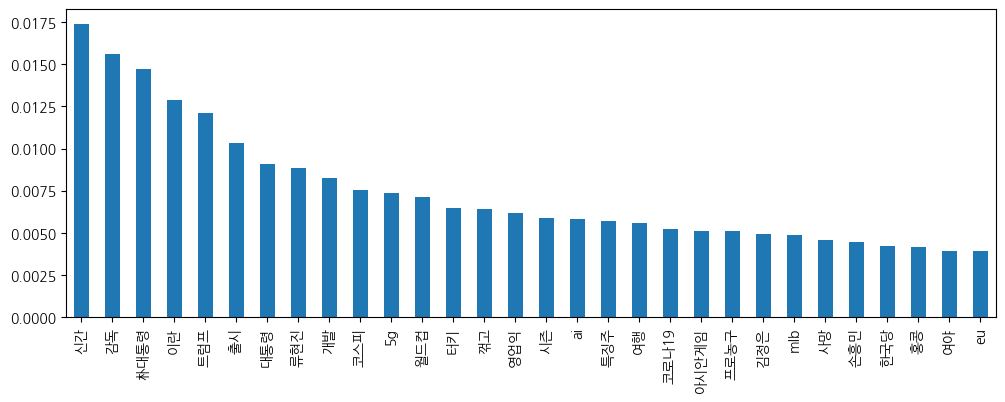

In [88]:
# feature_importances_
fi = pd.Series(best_model.feature_importances_)
fi.index = tfidfvect.get_feature_names_out()
fi.nlargest(30).plot(kind="bar", figsize=(12, 4))

## 정답값 로드

In [89]:
# sample_submission 파일을 불러옵니다.
# Dacon 에 제출할 답안지 양식입니다.
submit = pd.read_csv("data/klue/sample_submission.csv")
submit.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [91]:
# 정답값 측정을 위해 y_test 변수에 할당
submit["topic_idx"] = y_predict

In [94]:
file_name = f"data/klue/submit_{valid_accuracy}.csv"
file_name

'data/klue/submit_0.6692294212993385.csv'

In [95]:
# 잘 저장이 되었는지 확인합니다.
submit.to_csv(file_name, index=False)

In [96]:
# 잘 저장이 되었는지 확인합니다.
pd.read_csv(file_name)

,index,topic_idx
0,45654,2
1,45655,3
2,45656,1
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,3
9128,54782,4
9129,54783,2


* dacon에 제출해서 리더보드 확인하기 : https://dacon.io/competitions/official/235747/mysubmission


## 여러 방법을 통해 예측비율을 높여보세요. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경